# Cloud SDK Tutorial

## About the development environment

Refer to Get Started's **2. Use Cloud SDK to visualize data/2.1. Building an Environment for the Development of the Cloud Application** for details on the environment. 

In [1]:
import os
import warnings

from console_access_library.client import Client
from console_access_library.common.config import Config
from console_access_library.common.read_console_access_settings import ReadConsoleAccessSettings

warnings.filterwarnings("ignore")

## Step1 Retrieve the Device list information connected to Console 

- 1. Create a client to connect to Console
- 2. Retrieve the Edge Device list information connected to Console

### 1. Retrieving the Client

* Call the `get_console_client` function and, using the connection destination information described in `console_access_settings.yaml`, a client used to connect to Console is created. For information on how to create a client, refer to [REST API authentication](https://developer.aitrios.sony-semicon.com/en/file/download/edge-ai-sensing-portal-console-end-point-info/).
* It is assumed that the `console_access_settings.yaml` file is placed in the same directory as `tutorial_sample.ipynb` but is is also possible to place it elsewhere by editing the file path of `console_access_settings_dir` according to what is needed.

```yaml:console_access_settings.yaml
console_access_settings:
  console_endpoint: "{console_endpoint}"
  portal_authorization_endpoint : "{portal_authorization_endpoint}"
  client_secret: "{client_secret}"
  client_id: "{client_id}"
```

In [2]:
def get_console_client():
    """Get access information from yaml and generate ConsoleAccess client
    Returns:
        ConsoleAccessClient: ConsoleAccessClient Class generated from access information.
    """
    console_access_settings_dir = "/workspace/src/data_loader/common/console_access_settings.yaml"
    read_console_access_settings_obj = ReadConsoleAccessSettings(console_access_settings_dir)
    config_obj = Config(
        read_console_access_settings_obj.console_endpoint,
        read_console_access_settings_obj.portal_authorization_endpoint,
        read_console_access_settings_obj.client_id,
        read_console_access_settings_obj.client_secret
    )
    client_obj = Client(config_obj)

    return client_obj

### 2. Creating a function to retrieve the Edge Device list information

Create the `get_devices` function with the following functionalities.  
1. Execute `client_obj.device_management.get_devices()` and retrieve the Edge Device information
2. Store the obtained device information in id_list and return it

In [37]:
def get_devices():
    try:
        client_obj = get_console_client()
        response = client_obj.device_management.get_devices()
        id_list = []
        for device_list in response["devices"]:
            id_list.append(device_list["device_id"])
        return id_list
    except Exception as error:
        raise Exception(str(error))

Execute the `get_devices` function. 

In [38]:
devices_list = get_devices()
print(devices_list)

['sid-100A50500A2004091364012000000000', 'sid-100A50500A2005095864012000000000', 'sid-100A50500A2012088964012000000000']


## Step2 Retrieve the image directory information for the selected Device 

Create the `get_image_directories` function that has the following functionality. 
1. Using the Device name retrieved earlier as an argument of `client_obj.insight.get_image_directories`, retrieve the image folder name associated with the Edge Device name. 

In [8]:
def get_image_directories(device_id):
    try:
        client_obj = get_console_client()
        response = client_obj.insight.get_image_directories(device_id)
        if len(response[0]["devices"][0]["Image"]) == 0:
            raise Exception("Cannot get direcotries.")
        return response[0]["devices"][0]["Image"]
    except Exception as error:
        raise Exception(str(error))


In [ ]:
# Selects an appropriate device_id from the devices_list array.
# In this tutorial, we select the top of the array, but you can also select by specifying a string of device_id.
device_id = devices_list[0]
#device_id = "sid-xxxxxxxxxxxxxxxxxxxxxxx"

image_directories = get_image_directories(device_id)
print(image_directories)

('20230612070317694', '20230612071139582', '20230612072258739', '20230612072702861', '20230613072353397', '20230613075551027')


## Step3 Retrieve and display the image information of the selected directory

Create the `get_devices` function with the following functionalities. 
1. Execute `client_obj.insight.get_images` to retrieve the images in the folder using one of the folders obtained previously as an argument. 

2. After executing device_images, one images from the group of images is selected and then drawn. 

**ATTENTION！**  
In the tutorial, after decoding the base64-encoded image string with the python standard library `base64`, the image is displayed using `PIL`.
Please use the appropriate library according to the purpose of the developer.

In [29]:
def get_images(device_id, device_directory_name):
    try:
        client_obj = get_console_client()
        response = client_obj.insight.get_images(
            device_id=device_id, sub_directory_name=device_directory_name
        )
        if len(response["images"]) == 0:
            raise Exception("Cannot get images.")
        return response["images"]
    except Exception as error:
        raise Exception(str(error))

In [ ]:
# install opencv and libraries
!pip install opencv-contrib-python
!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-dev
!pip install matplotlib

import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt

def base64_to_cv2(img_str):
    if "base64," in img_str:
        # For DATA URI, data:[<mediatype>][;base64], are excluded
        img_str = img_str.split(",")[1]
    
    # Decode Base64 string and convert to byte 
    img_data = base64.b64decode(img_str)
    
    # Convert byte to NumPy array
    nparr = np.frombuffer(img_data, np.uint8)
    
    # Convert NumPy array to OpenCV image format
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return image_rgb

Defaulting to user installation because normal site-packages is not writeable
Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Hit:3 https://dl.yarnpkg.com/debian stable InRelease      
Get:4 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [244 kB]
Fetched 337 kB in 1s (459 kB/s) 
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.3.5-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Defaulting to user installation because normal site-packages is not writeable


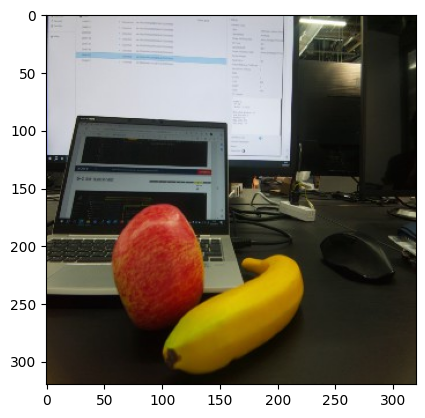

In [30]:
# Selects the image directory obtained by device_directory_name.
# In this tutorial, the first directory is selected.
images_data = get_images(device_id=device_id, device_directory_name=image_directories[0])

# Selects the latest image from the image group
image_name = images_data[-1]["name"]
img_base64 = images_data[-1]["contents"]

img = base64_to_cv2(img_base64)
plt.imshow(img)

## Step4 Retrieving the inference result associated with the selected image 

Create the `get_inference_results` function with the following functionality. 
1. Execute `client_obj.insight.get_inference_results` to retrieve the inference results using as arguments the device_id, the number of inference results to retrieve and the timestamp. 
Since the inference results are stored in a list, after retrieving the first inference result with `inference_list[0]`, the contents can be visualized by specifying the `O` key. 

In [ ]:
def get_inference_result(device_id, image_timestamp):
    try:
        client_obj = get_console_client()
        response = client_obj.insight.get_inference_results(
            device_id=device_id,
            number_of_inference_results=1,
            raw=1,
            time=image_timestamp,
        )
        print(response)
        if len(response[0]["inference_result"]["Inferences"]) == 0:
            print("Cannot get inference results.")
            raise Exception("Cannot get inference results.")
        return response[0]["inference_result"]["Inferences"]
    except Exception as error:
        raise Exception(str(error))

In [32]:
latest_image_ts = image_name.replace(".jpg", "")
print(latest_image_ts)
inference_list = get_inference_result(device_id=device_id, image_timestamp=latest_image_ts)
print(inference_list[0]["O"])

20230612070333844
(DynamicSchema({'id': '532598208288_1702421_1686553419.173', 'device_id': 'sid-100A50500A2012088964012000000000', 'model_id': '20230612_YUKI', 'version_number': '1.00', 'model_version_id': '0300000009230100', 'model_type': '01', 'training_kit_name': 'CustomVision-ObjectDetection', '_ts': Decimal('1686553419'), 'inferences': (DynamicSchema({'T': '20230612070333844', 'O': 'DAAAAAAABgAKAAQABgAAAAwAAAAAAAYACAAEAAYAAAAEAAAAAwAAAHQAAAA8AAAABAAAANj///8AAAABAQAAAAgAAAAAAAg+nP///wQAAABSAAAAqAAAAKcAAAAMABQACAAHAAwAEAAMAAAAAAAAAQEAAAAIAAAAAACEPtD///9oAAAAzgAAAOYAAAAvAQAADAAQAAAABwAIAAwADAAAAAAAAAEUAAAAAABlPwwAFAAEAAgADAAQAAwAAAA1AAAAogAAAI4AAAAQAQAA'}),)}),)
DAAAAAAABgAKAAQABgAAAAwAAAAAAAYACAAEAAYAAAAEAAAAAwAAAHQAAAA8AAAABAAAANj///8AAAABAQAAAAgAAAAAAAg+nP///wQAAABSAAAAqAAAAKcAAAAMABQACAAHAAwAEAAMAAAAAAAAAQEAAAAIAAAAAACEPtD///9oAAAAzgAAAOYAAAAvAQAADAAQAAAABwAIAAwADAAAAAAAAAEUAAAAAABlPwwAFAAEAAgADAAQAAwAAAA1AAAAogAAAI4AAAAQAQAA


## Step5 Deserializing the inference results

Using the deserializing code provided by [aitrios-sample-application-check-data-tool-python](https://github.com/SonySemiconductorSolutions/aitrios-sample-application-check-data-tool-python) decode to base64 format and deserialize using Flatbuffers.


<details><summary>get_deserialize_data.py</summary>

```.py
import base64
from src.common.deserialize import ObjectDetectionTop, BoundingBox, BoundingBox2d


def get_deserialize_data(serialize_data):
    """Get access information from yaml and generate ConsoleAccess client
    Returns:
        ConsoleAccessClient: CosoleAccessClient Class generated from access information.
    """
    buf = {}
    buf_decode = base64.b64decode(serialize_data)
    ppl_out = ObjectDetectionTop.ObjectDetectionTop.GetRootAsObjectDetectionTop(buf_decode, 0)
    obj_data = ppl_out.Perception()
    res_num = obj_data.ObjectDetectionListLength()
    for i in range(res_num):
        obj_list = obj_data.ObjectDetectionList(i)
        union_type = obj_list.BoundingBoxType()
        if union_type == BoundingBox.BoundingBox.BoundingBox2d:
            bbox_2d = BoundingBox2d.BoundingBox2d()
            bbox_2d.Init(obj_list.BoundingBox().Bytes, obj_list.BoundingBox().Pos)
            buf[str(i + 1)] = {}
            buf[str(i + 1)]['C'] = obj_list.ClassId()
            buf[str(i + 1)]['P'] = obj_list.Score()
            buf[str(i + 1)]['X'] = bbox_2d.Left()
            buf[str(i + 1)]['Y'] = bbox_2d.Top()
            buf[str(i + 1)]['x'] = bbox_2d.Right()
            buf[str(i + 1)]['y'] = bbox_2d.Bottom()

    return buf
```
</details>

`get_deserialize_data.py` is explained in detail below. 

1. First, the FlatBuffers schema under `src.common.deserialize` is imported.
  - If the object detection ppl provided by the preset of Console is being used, this file does not need to be modified.\

```python
from src.common.deserialize import ObjectDetectionTop, BoundingBox, BoundingBox2d
```

1. The inference result data retrieved from Console is decoded using base64. 

```python
buf_decode = base64.b64decode(serialize_data)
```

3. The previously decoded `buf_decode` is deserialized using `ObjectDetectionTop` in which the FlatBuffers library is wrapped. Afterwards, `Perception` is used to convert the data to python list type.

```python
ppl_out = ObjectDetectionTop.ObjectDetectionTop.GetRootAsObjectDetectionTop(buf_decode, 0)
obj_data = ppl_out.Perception()
```

4. A process to access the data field is carried out and the data is converted to dict type. 

```python
res_num = obj_data.ObjectDetectionListLength()
for i in range(res_num):
    obj_list = obj_data.ObjectDetectionList(i)
    union_type = obj_list.BoundingBoxType()
    if union_type == BoundingBox.BoundingBox.BoundingBox2d:
        bbox_2d = BoundingBox2d.BoundingBox2d()
        bbox_2d.Init(obj_list.BoundingBox().Bytes, obj_list.BoundingBox().Pos)
        buf[str(i + 1)] = {}
        buf[str(i + 1)]['C'] = obj_list.ClassId()
        buf[str(i + 1)]['P'] = obj_list.Score()
        buf[str(i + 1)]['X'] = bbox_2d.Left()
        buf[str(i + 1)]['Y'] = bbox_2d.Top()
        buf[str(i + 1)]['x'] = bbox_2d.Right()
        buf[str(i + 1)]['y'] = bbox_2d.Bottom()
```

In [33]:
print (os.getcwd())
os.chdir("/workspace/src")
print (os.getcwd())

/
/workspace/src


In [35]:
from data_deserializer import get_deserialize_data

deserialize_data = get_deserialize_data.get_deserialize_data(inference_list[0]["O"])
print(deserialize_data)

{'1': {'C': 0, 'P': 0.89453125, 'X': 53, 'Y': 162, 'x': 142, 'y': 272}, '2': {'C': 1, 'P': 0.2578125, 'X': 104, 'Y': 206, 'x': 230, 'y': 303}, '3': {'C': 1, 'P': 0.1328125, 'X': 4, 'Y': 82, 'x': 168, 'y': 167}}


## Step6 Superimposing the inference result on the image 

The previously deserialized result is superimposed as a rectangle in the image using the opencv library. 

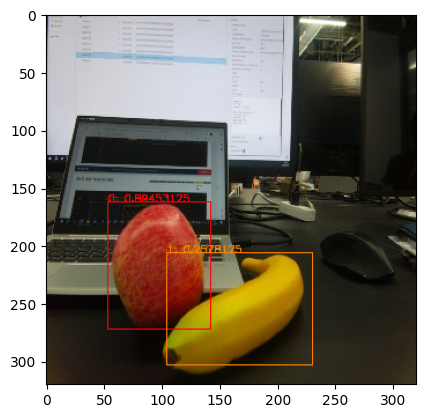

In [36]:
import cv2
import numpy as np

colors = [
(255, 0, 0),
(255, 128, 0),
(255, 255, 0),
(128, 255, 0),
(0, 255, 0),
(0, 255, 255),
(0, 128, 255),
(0, 0, 255),
(128, 0, 255),
(255, 0, 255),
(255, 0, 128),
(255, 255, 255),
(192, 192, 192),
(128, 128, 128),
(0, 0, 0),
  ]

img_np = np.array(img)
for index in range(len(deserialize_data)):
    color = colors[index]
    # Drawing the rectangle
    cv2.rectangle(img_np, (deserialize_data[str(index+1)]['X'], deserialize_data[str(index+1)]['Y']), (deserialize_data[str(index+1)]['x'], deserialize_data[str(index+1)]['y']), color\
              ,thickness=1, lineType=cv2.LINE_4, shift=0)
    # String {class id} : {score}
    class_text = str(deserialize_data[str(index+1)]['C']) + ': ' + str(deserialize_data[str(index+1)]['P'])
    cv2.putText(img_np,
            text=class_text,
            org=(deserialize_data[str(index+1)]['X'], deserialize_data[str(index+1)]['Y']),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            color=color,
            thickness=1,
            lineType=cv2.LINE_4)
    if index == 1:
        break
plt.imshow(img_np)